# About this Practical Session

In this practical session, we will utilize the metapopulation model developed in the previous notebook to examine different scenarios of disease spread.

In particular, we will perform the following steps:
1. Create and use the metapopulation class
2. Synchronization examples
3. Real-case scenario using data from the first practical session
4. Hub infection dynamics

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from copy import copy, deepcopy

import os
import geopandas as gpd

rng = np.random.default_rng() # random number generator
from itertools import combinations
import time

# 1) The Metapopulation class

## Definition
Here is defined the Metapopulation class. It integrates the code from the last notebook into a class that is easy to use.

In [2]:
def transitions(comp, inc, fromCompartment, toCompartment, rate, step, rng):
    '''
    This function modifies the arrays `comp` (compartment occupancy for each patch) and `inc` (compartment incidence for each patch).
    It updates the values at the given `step` to account for the transition between compartments based on binomial extractions.
    It assume the comp array at `step` is filled with the values of comp array at `step-1`

    Parameters:
    - comp: 3D array, compartment occupancy for each patch over time
    - inc: 3D array, compartment incidence for each patch over time
    - fromCompartment: int, index of the compartment transitioning from
    - toCompartment: int, index of the compartment transitioning to
    - rate: float or array-like, transition rate or rates for each patch
    - step: int, current time step of the simulation

    Example:
    transitions(comp, inc, 1, 2, eps, 20) --> transitions from compartment 1 (E) to compartment 2 (I) with rate eps at time step 20
    '''
    
    transitions = rng.binomial(comp[step-1, :, fromCompartment], 1-np.exp(-rate))
    
    comp[step, :, toCompartment] += transitions
    comp[step, :, fromCompartment] -= transitions

    inc[step, :, toCompartment] += transitions


In [3]:
class metapopSEIR():
    '''
    The `metapopSEIR` class implements a simulation of a metapopulation SEIR.

    Parameters:
    ----------
    beta : float
        Transmission rate of the disease.
    eps : float
        Rate of transition from exposed (E) to infectious (I) state.
    mu : float
        Rate of transition from infectious (I) to recovered (R) state.
    populations : pd.DataFrame
        DataFrame containing population sizes of each patch.
    travels : pd.DataFrame
        DataFrame specifying the travel between patches, including the number of passengers.
    initE : int
        Initial number of exposed individuals in a specified patch.
    initPatch : int
        Index of the patch where initial exposed individuals are located.
    nSteps : int
        Number of simulation steps to run.

    
    Methods:
    -------
    run():
        Runs the simulation 

    getPrevalence():
        Returns a DataFrame containing the prevalence (total count) of each SEIR compartment (S, E, I, R) for each patch over time.

    getIncidence():
        Returns a DataFrame containing the incidence (new cases) of each SEIR compartment (S, E, I, R) for each patch over time.
    '''

    
    def __init__(self, 
                 beta:'float',
                 eps:'float',
                 mu:'float',
                 populations:'pd.DataFrame',
                 travels:'pd.DataFrame',
                 initE:'int', 
                 initPatch:'int',
                 nSteps:'int',
                ):
        
        self.nameCompartmens = ['S','E','I','R']
        self.beta, self.eps, self.mu = beta, eps, mu    
        self.populations = populations.copy()
        self.travels = travels.copy()
        self.initE = initE
        self.initPatch = initPatch
        self.nSteps = nSteps
        self.rng = np.random.default_rng(int(time.time()))
        
        self.nCompartmens = 4
        self.nPatches = len(populations)
    
        self.comp = np.zeros((self.nSteps, self.nPatches, self.nCompartmens), dtype=np.int64)
        self.inc = np.zeros((self.nSteps, self.nPatches, self.nCompartmens), dtype=np.int64)
        self.incT = np.zeros((self.nSteps, self.nPatches, self.nCompartmens), dtype=np.int64)

        self.setInitialCondition()
        self.modifytravels()
    
    def setInitialCondition(self):
        self.comp[0,:,0] = self.populations['pop'].values
        
        self.comp[0,self.initPatch,1] += self.initE
        self.comp[0,self.initPatch,0] -= self.initE
        self.inc[0,self.initPatch,1] += self.initE

    def modifytravels(self):
        '''
        This function modify the provided travels dataset by creating a symmetric mobility matrix that contains the probability of travel between each couple of patches
        '''
        # create a symmetric matrix of travels 
        self.travels = self.travels[['passengers']]
        travelsMatrix = pd.concat([self.travels, self.travels.rename_axis(['to','from']).reorder_levels((1,0))])
        travelsMatrix = travelsMatrix.unstack().fillna(0)
        travelsMatrix = travelsMatrix.sort_index(axis=1).sort_index(axis=1)
        
        #fill diagonal 
        np.fill_diagonal(travelsMatrix.values, self.populations['pop'] - travelsMatrix.sum(1))
        
        #divide by population --> probability of travels
        travelsMatrix = travelsMatrix.divide(self.populations['pop'], axis=0)
        
        self.travelsMatrix = travelsMatrix 


    def run(self):
        for currentStep in np.arange(1,self.nSteps): 
        
            
            # disease step 
            self.comp[currentStep, :, :] = self.comp[currentStep-1, :, :]
            # spontaneous E-->I and I-->R
            transitions(comp=self.comp, inc=self.inc, fromCompartment=1, toCompartment=2, rate=self.eps, step=currentStep, rng=self.rng)
            transitions(comp=self.comp, inc=self.inc, fromCompartment=2, toCompartment=3, rate=self.mu, step=currentStep, rng=self.rng)
        
            # mediated transition S-->E
            mediatedRate = self.beta * self.comp[currentStep-1,:,2] / self.comp[currentStep-1,:,:].sum(1)
            transitions(comp=self.comp, inc=self.inc, fromCompartment=0, toCompartment=1, rate=mediatedRate, step=currentStep, rng=self.rng)

            # travle step 
            self.comp[currentStep,:,:] = self.rng.multinomial(self.comp[currentStep,:,:].T, self.travelsMatrix.values).T.sum(1)

        return self
    
    def getPrevalence(self):
        df = pd.DataFrame(self.comp.reshape(-1, self.nCompartmens * self.nPatches))
        df.columns = pd.MultiIndex.from_product((self.populations['name'],self.nameCompartmens), names=['patch','compartment'])   
        return df 

    def getIncidence(self):
        df = pd.DataFrame(self.inc.reshape(-1, self.nCompartmens * self.nPatches))
        df.columns = pd.MultiIndex.from_product((self.populations['name'],self.nameCompartmens), names=['patch','compartment'])   
        return df 
        

## Usage of the metapopulation class

In [5]:
# Define population dataset
population = [1e4, 1e3, 1e4] 
namePatches = [f'patch {i}' for i in range(len(population))] 
populations = pd.DataFrame(zip(population, namePatches), columns=['pop', 'name'])  
populations.head()

,pop,name
0,10000.0,patch 0
1,1000.0,patch 1
2,10000.0,patch 2


In [6]:
# Define travel dataset
travels = pd.DataFrame([[0,1,20],[1,2,200]], columns=['from', 'to', 'passengers']).set_index(['from','to'])
travels.head(2)

,,passengers
from,to,
0,1,20
1,2,200


In [7]:
# Define and run a model, look at the documentation
...
model = metapopSEIR(beta = 0.5,
                    eps = 0.2,
                    mu = 0.2,
                    populations = populations,
                    travels = travels,
                    initE = 10,
                    initPatch = 2,
                    nSteps = 700)
model.run();

In [8]:
prev = model.getPrevalence()
prev.head()

patch       patch 0          patch 1          patch 2          
compartment       S  E  I  R       S  E  I  R       S   E  I  R
0             10000  0  0  0    1000  0  0  0    9990  10  0  0
1             10003  0  0  0     961  0  0  0   10026   9  1  0
2             10011  0  0  0     931  0  0  0   10048   9  0  1
3             10010  0  0  0     932  0  0  0   10048   9  0  1
4              9998  0  0  0     951  0  0  0   10041   9  0  1

In [9]:
# Access data of a single patch
res = prev.loc[slice(None), ('patch 1', slice(None))]
res.head()

patch       patch 1         
compartment       S  E  I  R
0              1000  0  0  0
1               961  0  0  0
2               931  0  0  0
3               932  0  0  0
4               951  0  0  0

In [10]:
# Access data of a single compartment
res = prev.loc[slice(None), (slice(None), 'E')]
res.head()

patch,patch 0,patch 1,patch 2
compartment,E,E,E
0,0,0,10
1,0,0,9
2,0,0,9
3,0,0,9
4,0,0,9


In [11]:
# Access data of a single compartment in a single patch
res = prev.loc[slice(None), ('patch 2', 'E')]
res.head()

0    10
1     9
2     9
3     9
4     9
Name: (patch 2, E), dtype: int64

# 2) Syncronization 

![Metapop Setting 1](https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/60eeb2305fe2dcb0048f928b5ca49837dc8b71c5/figures/metapopSetting1.png)

In [38]:
# Define population dataset
population = [1e3, 0.5e7, 1e7] 
namePatches = [f'patch {i}' for i in range(len(population))] 
populations = pd.DataFrame(zip(population, namePatches), columns=['pop', 'name'])  

In [53]:
travels = pd.DataFrame([[0,1,1],[1,2,2]], columns=['from', 'to', 'passengers']).set_index(['from','to'])

model = metapopSEIR(beta = 0.2,
                    eps = 0.5,
                    mu = 0.17,
                    populations = populations,
                    travels = travels,
                    initE = 10,
                    initPatch = 0,
                    nSteps = 800)
model.run()
prev = model.getPrevalence()
inc = model.getIncidence()

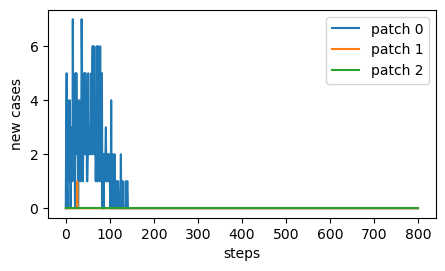

In [54]:
fig, ax = plt.subplots(figsize=(5, 2.7))
for name,incidence in inc.loc[slice(None), (slice(None), 'I')].items():
    ax.plot(incidence.index, incidence.values, label=name[0])

ax.set_ylabel("new cases")
ax.set_xlabel("steps")
ax.legend()

In [ ]:
...

In [ ]:
...

In [ ]:
...

# Run multiple experiment function

In [ ]:
def getIncidenceMultipleRun(model, n=10):
    '''
    Run model n times and get the number new infections
    '''
    incs = list()
    for i in range(n):
        _model = deepcopy(model)
        _model.rng = np.random.default_rng(np.random.randint(1e7))
        inc = _model.run().getIncidence()
        
        inc.columns = pd.MultiIndex.from_product([[f'exp_{i}']] + inc.columns.levels)
        incs.append(inc)
        
    return pd.concat(incs, axis=1)

In [ ]:
# Define population dataset
population = [1e7, 1e7, 1e7] 
namePatches = [f'patch {i}' for i in range(len(population))] 
populations = pd.DataFrame(zip(population, namePatches), columns=['pop', 'name'])  

In [ ]:
travels = pd.DataFrame([[0,1,100],[0,2,100]], columns=['from', 'to', 'passengers']).set_index(['from','to'])

model = metapopSEIR(beta = 0.25,
                    eps = 0.4,
                    mu = 0.17,
                    populations = populations,
                    travels = travels,
                    initE = 10,
                    initPatch = 0,
                    nSteps = 600)

inc = getIncidenceMultipleRun(model, n=10)

In [ ]:
inc.head()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.7))

df = inc.loc[:, (slice(None),'patch 0','I')] #HOW to selcet the new infected of patch 0

ax.plot(df.index, df.values, c='C0', alpha=0.7)
df = inc.loc[:, (slice(None),'patch 1','I')]

ax.plot(df.index, df.values, c='C1', alpha=0.7)
df = inc.loc[:, (slice(None),'patch 2','I')]
ax.plot(df.index, df.values, c='C2', alpha=0.7);ax.set_ylabel("new cases")

# Travel restrictions

![Metapop Setting 2](https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/60eeb2305fe2dcb0048f928b5ca49837dc8b71c5/figures/metapopSetting2.png)

Experiment with various population sizes, travel flows, and network topologies!

In [ ]:
...

# 3) Real Case
In this section, a real-case scenario using the US states as patches and the state-to-state mobility data from the first practical session.  
We will simulate the disease spread from different source states and plot the cumulative incidence on a map at various time steps to visualize the spread.

## Load the datasets

In [ ]:
# Load the geojson file with county shapes
# if executed on Google Colab change the path in 'https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-counties.geojson'

geoData = gpd.read_file('./otherData/US-states.geojson')
geoData = geoData.to_crs("ESRI:102003")
geoData = geoData.set_index('GEOID')

# For visualizaiton pourpose remove Alaska, Hawaii and Puerto Rico.
geoData = geoData.query('STATEFP not in ["02", "15", "72", "78", "60", "66", "69"]')
geoData.head(2)

In [ ]:
# Load population of US states
# if executed on Google Colab change the path in https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-pop-states.csv'

popState = pd.read_csv("./otherData/US-pop-states.csv")
popState['state'] = popState['state'].astype(str)
popState['state'] = popState['state'].apply(lambda a: a.zfill(2)) 

popState.columns = ['name','pop']
popState.head(2)

In [ ]:
# Load states to state passenfer flow
# if on google colabs use 'https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowStateAvg.csv'

s2s = pd.read_csv('./mobilityflows/mobilityFlowStateAvg.csv')
s2s[['state_o','state_d']] = s2s[['state_o','state_d']].astype(str)
s2s[['state_o','state_d']] = s2s[['state_o','state_d']].map(lambda a: a.zfill(2)) 

s2s.head(2)

In [ ]:
# Take the average flow between each couple of states
...

s2s.head(2)

In [ ]:
# In the `Metapopulation` class, it's crucial that the travel DataFrame has the same index as the population dataset.
# The following code ensures this consistency

mapIndexState = popState['name'].to_dict()
mapStateIndex = {v: k for k, v in mapIndexState.items()}

s2s['state_o'] = s2s['state_o'].map(mapStateIndex)
s2s['state_d'] = s2s['state_d'].map(mapStateIndex)

s2s = s2s.set_index(['state_o','state_d'])
s2s.index.names = ['from', 'to']
s2s.columns = ['passengers']
s2s.head(2)

## Run the model

In [ ]:
# Select a source and run the model
...

In [ ]:
# get for each patch the cumulative incidence at a certain timestep
incidence = model.getIncidence().loc[:, (slice(None),'I')]
incidence = incidence.droplevel('compartment', axis=1)

# use cumsum to get the cumulative number of new cases
...

# select a timestep
...


# divide by population
...


incidence.name = 'incidence' #give a name to the pd.Series so that we cna merge it 

# Merge geoData
...


In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), ncols=1, layout='constrained')
ax.axis('off')

geoDataWithInc.plot(facecolor='None', linewidth=.3, ax=ax);
geoDataWithInc.plot(column='incidence', cmap='Reds', ax=ax, legend=True, legend_kwds= {'label': "Cumulative incidence %"})

sourceCode = popState.loc[source, 'name']
geoDataWithInc.loc[[sourceCode]].plot(facecolor='None', ax=ax, hatch='////', edgecolor='white')

# 4) Hub-Peripheral Source Dynamics 

In metapopulation models, large patches typically infect other large patches due to higher travels volumes and dense connectivity between them, facilitating faster disease spread among these hubs. Conversely, small patches tend to infect large patches first because of essential travels links, despite lower overall connectivity. This results in an asymmetric infection dynamic where large patches are primarily responsible for propagating the disease among themselves, while small patches contribute to initial outbreaks in larger patches due to directional travels bias. 

Show that this is the case by doing the following steps:
1) Creating a population dataset with different dimension
2) Use a gravity model for estimate the number of passenger between two patches (assume that the distance costant between all the patches)
3) Run the metapopulation model using different sources
4) Plot the cumulate incidence and observe the delay in the outbreak across different patches

Suggenstion: use the gravity model we fitted in the last practical lesson:
$$T_{ij} = K \frac{P_i^{a} P_j^{b}}{D_{ij}^{c}}$$
 
$K = 4 \times 10^{-5}$  
$a = b = 0.85$  
$c = 1.1$  

In [ ]:
# Define population dataset
# Create patches with big/medium/small population
...

In [ ]:
# Define travel dataset from the gravity model
# Step 1: create a dataset that contian the population for each combination of patches
travels = pd.DataFrame(list(combinations(populations.index, 2)), columns=['from', 'to'])
travels = travels.merge(populations[['pop']].add_suffix('_from'), left_on='from', right_index=True)
travels = travels.merge(populations[['pop']].add_suffix('_to'), left_on='to', right_index=True)
travels = travels.set_index(['from', 'to'])
travels.head(2)

In [ ]:
# Step 2: Add the 'passenger' column to the dataset, using the gravity model 
...

## Hub Source

- Introduce the disease in a patch with a large population.
- Plot the cumulative incidence using a logarithmic scale.
- Analyze the delay in outbreak onset across various patches.

In [ ]:
# Define the model
...


In [ ]:
# Get incidence in compartment I and compute the cumulative sum (pandas function cumsum())
# Call the result incCum
...


In [ ]:
# Plot incCum
fig, ax = plt.subplots(figsize=(5, 5))

incCum.iloc[:].plot(ax=ax)

plt.yscale('log')
ax.set_ylabel("cumulative incidence")
ax.set_xlabel("step")

## Peripheral Source

- Introduce the disease in a source patch with a small population.
- Plot the cumulative incidence using a logarithmic scale.
- Analyze the delay in outbreak onset across various patches.


In [ ]:
# Define the model
...

In [ ]:
# Get incidence in compartment I and compute the cumulative sum (pandas function cumsum())
# Call the result incCum
...

In [ ]:
# Plot incCum
fig, ax = plt.subplots(figsize=(5, 5))

incCum.plot(ax=ax)

plt.yscale('log')
ax.set_ylabel("cumulative incidence")
ax.set_xlabel("step")